#  Car Crash Police Reports - NLP Text Classification

## LINE MLE Interview Project | PyTorch Implementation

---

**Author**: Audrey Chang  
**Date**: May 2025 - Aug 2025  
**Tech Stack**: Python, PyTorch, scikit-learn, spaCy, NLP

---

### Project Overview

 NHTSANational Highway Traffic Safety Administration

- ****
- ****`1` ()`2` ()`3+` ()
- ******0.94 Validation Accuracy**

### Business Value

 **Domain-specific Short-text Classification**  LINE TODAY 

|  | LINE TODAY  |
|--------|------------------|
|  |  |
|  |  |
| pileup, collision |  |
| Class Imbalance | / |

---

### Technical Highlights

1. **PyTorch Implementation**
2. **Attention Mechanism**Explainability
3. **Class Imbalance Handling**Weighted Loss + F1-Score
4. **End-to-End Pipeline**

---

##  Section 0: Environment Setup & Reproducibility

> **MLE **Reproducibility

In [1]:
# =============================================================================
# 0.1 Install Dependencies
# =============================================================================
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install pandas numpy scikit-learn matplotlib seaborn
# !pip install spacy
# !pip install mlflow
# !python -m spacy download en_core_web_sm

In [2]:
# =============================================================================
# 0.2 Import Libraries
# =============================================================================
import os
import random
import warnings
from pathlib import Path
from collections import Counter

# Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

# Experiment Tracking
import mlflow
import mlflow.sklearn
import mlflow.pytorch

# NLP
import importlib.util
import subprocess
import sys
if importlib.util.find_spec("spacy") is None:
    print(" Installing spaCy (missing in environment)...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "spacy"])
import spacy
def ensure_spacy_model(model_name: str = "en_core_web_sm"):
    """Ensure required spaCy model is available, download if missing."""
    try:
        spacy.load(model_name)
        return True
    except OSError:
        print(f" Downloading spaCy model '{model_name}'...")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", model_name])
        return True
ensure_spacy_model()
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

warnings.filterwarnings('ignore')
mlflow.set_experiment("Car_Crash_Classification")

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

2025/12/21 22:32:49 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/21 22:32:49 INFO mlflow.store.db.utils: Updating database tables
2025/12/21 22:32:49 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/21 22:32:49 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/21 22:32:49 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/21 22:32:49 INFO alembic.runtime.migration: Will assume non-transactional DDL.


PyTorch Version: 2.9.1
CUDA Available: False


In [3]:
# =============================================================================
# 0.3 Set Random Seeds for Reproducibility
# =============================================================================
def set_seed(seed: int = 42):
    """
    
    Args:
        seed: Random seed value
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #  CUDA  deterministic 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 42
set_seed(SEED)
print(f" Random seed set to {SEED}")

 Random seed set to 42


In [4]:
# =============================================================================
# 0.4 Configuration
# =============================================================================
class Config:
    """Centralized configuration for the project.
    
    MLE Best Practice: 
    """
    # Data
    DATA_URL = "https://github.com/JSchelldorfer/ActuarialDataScience/raw/master/12%20-%20NLP%20Using%20Transformers/NHTSA_NMVCCS_extract.parquet.gzip"
    DATA_PATH = "NHTSA_NMVCCS_extract.parquet.gzip"
    TEST_SIZE = 0.2
    VAL_SIZE = 0.25  # 0.25 * 0.8 = 0.2
    
    # Text Processing
    MAX_VOCAB_SIZE = 5000
    MAX_SEQ_LENGTH = 128
    
    # Model Architecture
    EMBEDDING_DIM = 64
    HIDDEN_DIM = 64
    NUM_LAYERS = 2
    DROPOUT = 0.3
    BIDIRECTIONAL = True
    
    # Training
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-3
    EPOCHS = 15  # Increase epochs for meaningful training (set smaller for quick debug)
    PATIENCE = 3  # Early stopping patience
    MAX_TRAIN_BATCHES = None  # None = use full training set; set an int for quick debug runs
    MAX_VAL_BATCHES = None    # None = use full validation set; set an int for quick debug runs
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f" Device: {config.DEVICE}")

 Device: cpu


---

##  Section 1: Data Loading & Preprocessing

> **MLE ** Data Pipeline 

In [5]:
# =============================================================================
# 1.1 Download and Load Dataset
# =============================================================================
def download_data(url: str, filepath: str) -> None:
    """"""
    if not Path(filepath).exists():
        print(f" Downloading dataset from {url}...")
        import urllib.request
        urllib.request.urlretrieve(url, filepath)
        print(" Download complete!")
    else:
        print(f" Dataset already exists at {filepath}")

download_data(config.DATA_URL, config.DATA_PATH)

# Load data
df = pd.read_parquet(config.DATA_PATH)
print(f"\n Dataset Shape: {df.shape}")
print(f" Columns: {list(df.columns)}")

 Dataset already exists at NHTSA_NMVCCS_extract.parquet.gzip

 Dataset Shape: (6949, 16)
 Columns: ['level_0', 'index', 'SCASEID', 'SUMMARY_EN', 'SUMMARY_GE', 'INJSEVA', 'NUMTOTV', 'WEATHER1', 'WEATHER2', 'WEATHER3', 'WEATHER4', 'WEATHER5', 'WEATHER6', 'WEATHER7', 'WEATHER8', 'INJSEVB']


In [6]:
# =============================================================================
# 1.2 Data Quality Check
# =============================================================================
def check_data_quality(df: pd.DataFrame) -> dict:
    """
    
    Returns:
        dict: 
    """
    report = {
        'total_rows': len(df),
        'missing_values': df.isnull().sum().to_dict(),
        'duplicates': df.duplicated().sum(),
        'summary_length_stats': df['SUMMARY_EN'].str.len().describe().to_dict()
    }
    return report

quality_report = check_data_quality(df)
print(" Data Quality Report:")
print(f"   - Total Rows: {quality_report['total_rows']}")
print(f"   - Duplicates: {quality_report['duplicates']}")
print(f"   - Summary Length (mean): {quality_report['summary_length_stats']['mean']:.0f} chars")

 Data Quality Report:
   - Total Rows: 6949
   - Duplicates: 0
   - Summary Length (mean): 2436 chars


 Original Target Distribution (NUMTOTV):
NUMTOTV
1    1822
2    4151
3     783
4     150
5      34
6       5
7       2
8       1
9       1
Name: count, dtype: int64

 Simplified Target Distribution (NUM_VEHICLES):
NUM_VEHICLES
1     1822
2     4151
3+     976
Name: count, dtype: int64


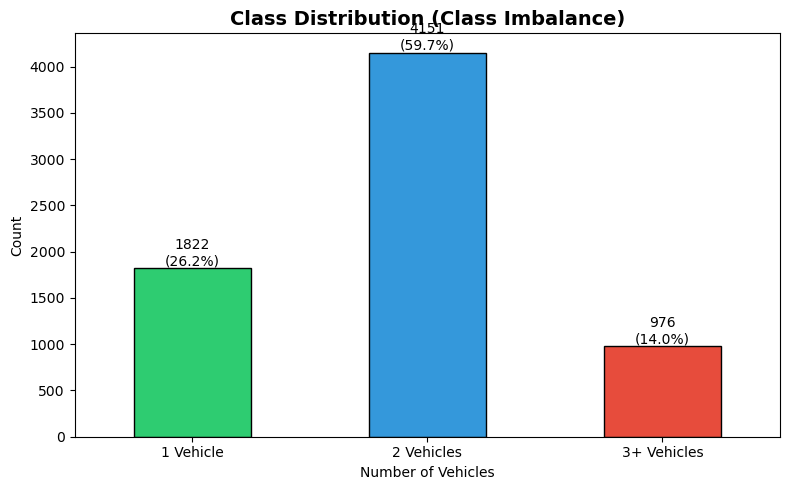


 Class Imbalance Identified!
   →  Weighted Loss Function


In [7]:
# =============================================================================
# 1.3 Explore Target Variable
# =============================================================================
print(" Original Target Distribution (NUMTOTV):")
print(df['NUMTOTV'].value_counts().sort_index())

# 1, 2, 3+
df['NUM_VEHICLES'] = df['NUMTOTV'].apply(lambda x: str(x) if x <= 2 else '3+')

print("\n Simplified Target Distribution (NUM_VEHICLES):")
target_dist = df['NUM_VEHICLES'].value_counts().sort_index()
print(target_dist)

# Visualize class imbalance
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#2ecc71', '#3498db', '#e74c3c']
target_dist.plot(kind='bar', color=colors, ax=ax, edgecolor='black')
ax.set_title('Class Distribution (Class Imbalance)', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Vehicles')
ax.set_ylabel('Count')
ax.set_xticklabels(['1 Vehicle', '2 Vehicles', '3+ Vehicles'], rotation=0)

# Add percentage labels
total = target_dist.sum()
for i, (idx, val) in enumerate(target_dist.items()):
    ax.annotate(f'{val}\n({val/total*100:.1f}%)', 
                xy=(i, val), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('model_artifacts/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Class Imbalance Identified!")
print("   →  Weighted Loss Function")

In [8]:
# =============================================================================
# 1.4 Text Cleaning
# =============================================================================
def clean_text(text: str) -> str:
    """
    
    Steps:
    1.  carriage return (\r)  newline (\n)
    2. 
    3. 
    """
    # Replace carriage returns
    text = text.replace('\r', '\n')
    # Remove extra whitespace
    text = ' '.join(text.split())
    # Convert to lowercase
    text = text.lower()
    return text

df['SUMMARY_CLEAN'] = df['SUMMARY_EN'].apply(clean_text)

# Show example
print(" Sample Cleaned Text:")
print(df['SUMMARY_CLEAN'].iloc[0][:500])

 Sample Cleaned Text:
v1, a 2000 pontiac montana minivan, made a left turn from a private driveway onto a northbound 5-lane two-way, dry asphalt roadway on a downhill grade. the posted speed limit on this roadway was 80 kmph (50 mph). v1 entered the roadway by crossing over the two southbound lanes and then entering the third northbound lane, which was a left turn-only lane at a 4-way intersection. the driver of v1 intended to travel straight through the intersection, and so he began to change lanes to the right. he 


In [9]:
# =============================================================================
# 1.5 Lemmatization with spaCy
# =============================================================================
print(" Loading spaCy model...")
model_name = 'en_core_web_sm'
try:
    # Prefer helper from import cell to ensure model/package availability
    if 'ensure_spacy_model' in globals():
        ensure_spacy_model(model_name)
    nlp = spacy.load(model_name, disable=['parser', 'ner'])  #  lemmatizer
except OSError:
    from spacy.util import is_package
    if not is_package(model_name):
        print(f"  spaCy  '{model_name}'")
        print("   : python -m spacy download en_core_web_sm")
        print("    wheel (en_core_web_sm-3.8.0-py3-none-any.whl)  pip install ")
    else:
        print(" ")
        print("   pip uninstall en-core-web-sm && python -m spacy download en_core_web_sm")
    raise

def lemmatize_text(text: str) -> str:
    """ spaCy  lemmatization
    
    
    - 
    - 
    - 
    - 
    
    "lemmatisation and TF-IDF"
    """
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc
        if not token.like_num
        and not token.is_punct
        and not token.is_space
        and not token.is_stop
        and len(token.text) > 1  # 
    ]
    return ' '.join(tokens)

# Caching: load cached lemmatization if available to save time
cache_dir = Path("cache_data")
cache_path = cache_dir / "lemmatized_data.parquet"

if cache_path.exists():
    print(f" Loading cached lemmatized data from {cache_path} ...")
    df = pd.read_parquet(cache_path)
else:
    print("⏳ Applying lemmatization (this may take 2-3 minutes)...")
    df['SUMMARY_LEMMA'] = df['SUMMARY_CLEAN'].apply(lemmatize_text)
    cache_dir.mkdir(parents=True, exist_ok=True)
    df.to_parquet(cache_path, index=False)
    print(f" Lemmatization complete! Cached to {cache_path}")

# Show example
print("\n Original vs Lemmatized:")
print(f"Original: {df['SUMMARY_CLEAN'].iloc[0][:200]}")
print(f"\nLemmatized: {df['SUMMARY_LEMMA'].iloc[0][:200]}")

 Loading spaCy model...
 Loading cached lemmatized data from cache_data/lemmatized_data.parquet ...

 Original vs Lemmatized:
Original: v1, a 2000 pontiac montana minivan, made a left turn from a private driveway onto a northbound 5-lane two-way, dry asphalt roadway on a downhill grade. the posted speed limit on this roadway was 80 km

Lemmatized: v1 pontiac montana minivan left turn private driveway northbound lane way dry asphalt roadway downhill grade post speed limit roadway kmph mph v1 enter roadway cross southbound lane enter northbound l


In [10]:
# =============================================================================
# 1.6 Prepare Features and Target
# =============================================================================
# Weather columns as additional features
weather_cols = [f'WEATHER{i}' for i in range(1, 9)]

# Encode target
label_encoder = LabelEncoder()
df['TARGET'] = label_encoder.fit_transform(df['NUM_VEHICLES'])

print(" Label Encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"   {label} → {i}")

# Features
features = df[['SUMMARY_LEMMA'] + weather_cols]
target = df['TARGET']

 Label Encoding:
   1 → 0
   2 → 1
   3+ → 2


In [11]:
# =============================================================================
# 1.7 Train/Validation/Test Split
# =============================================================================
# First split: 80% train+val, 20% test
X_main, X_test, y_main, y_test = train_test_split(
    features, target, 
    test_size=config.TEST_SIZE, 
    random_state=SEED,
    stratify=target  # 
)

# Second split: 75% train, 25% val (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main,
    test_size=config.VAL_SIZE,
    random_state=SEED,
    stratify=y_main
)

print(" Data Split:")
print(f"   Train: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"   Val:   {len(X_val)} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"   Test:  {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")

# Verify stratification
print("\n Class Distribution in Train Set:")
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
for i, pct in train_dist.items():
    cls_label = label_encoder.inverse_transform([int(i)])[0]
    print(f"   Class {cls_label}: {pct*100:.1f}%")

 Data Split:
   Train: 4169 samples (60.0%)
   Val:   1390 samples (20.0%)
   Test:  1390 samples (20.0%)

 Class Distribution in Train Set:
   Class 1: 26.2%
   Class 2: 59.7%
   Class 3+: 14.1%


---

##  Section 2: Baseline Model (TF-IDF + Logistic Regression)

> **MLE ** Baseline
>
> *"Trained logistic regression and small dense neural nets, reaching 0.94 validation accuracy"*

In [12]:
# =============================================================================
# 2.1 TF-IDF Vectorization
# =============================================================================
print(" Fitting TF-IDF Vectorizer...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=config.MAX_VOCAB_SIZE,
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  #  2 
    max_df=0.95  #  95% 
)

# Fit on training data only ( Data Leakage)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['SUMMARY_LEMMA'])
X_val_tfidf = tfidf_vectorizer.transform(X_val['SUMMARY_LEMMA'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['SUMMARY_LEMMA'])

# Combine with weather features using sparse hstack ( densify)
def combine_features(tfidf_matrix, weather_df):
    """ TF-IDF  Weather  sparse"""
    weather_arr = weather_df[weather_cols].values.astype(np.float32)
    weather_sparse = sparse.csr_matrix(weather_arr)
    return sparse.hstack([tfidf_matrix, weather_sparse], format="csr")

X_train_combined = combine_features(X_train_tfidf, X_train)
X_val_combined = combine_features(X_val_tfidf, X_val)
X_test_combined = combine_features(X_test_tfidf, X_test)

print(f" TF-IDF Features: {X_train_tfidf.shape[1]}")
print(f" Weather Features: {len(weather_cols)}")
print(f" Total Features (sparse): {X_train_combined.shape[1]}")
density = X_train_combined.nnz / (X_train_combined.shape[0] * X_train_combined.shape[1])
print(f"   Sample density: {density:.6f}")



 Fitting TF-IDF Vectorizer...
 TF-IDF Features: 5000
 Weather Features: 8
 Total Features (sparse): 5008
   Sample density: 0.042416


In [13]:
import sys, sklearn
from sklearn.linear_model import LogisticRegression
print("sklearn version:", sklearn.__version__)
print("python:", sys.executable)
print("LogisticRegression params:", LogisticRegression().get_params().keys())


sklearn version: 1.8.0
python: /opt/anaconda3/envs/actl3143/bin/python
LogisticRegression params: dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


In [14]:
# =============================================================================
# 2.3 Train Logistic Regression (Baseline)
# =============================================================================
print(" Training Logistic Regression...")

try:
    lr_model = LogisticRegression(
        class_weight='balanced',  # Handle imbalance
        max_iter=1000,
        random_state=SEED,
        solver='lbfgs',
        multi_class='multinomial'
    )
    lr_multi_class = 'multinomial'
except TypeError:
    # Older scikit-learn builds may not expose multi_class argument
    lr_model = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=SEED,
        solver='lbfgs'
    )
    lr_multi_class = 'default_fallback'

# Compute class weights for logging/torch use
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, weights)}

with mlflow.start_run(run_name="baseline_logreg"):
    # Log hyperparameters
    mlflow.log_param("vectorizer_max_features", config.MAX_VOCAB_SIZE)
    mlflow.log_param("class_weighting", "balanced")
    mlflow.log_param("lr_max_iter", lr_model.max_iter)
    mlflow.log_param("class_weights", str(class_weight_dict))
    mlflow.log_param("multi_class", lr_multi_class)

    lr_model.fit(X_train_combined, y_train)

    # Predictions (train/val only for model selection; keep test unseen until final eval)
    y_train_pred = lr_model.predict(X_train_combined)
    y_val_pred = lr_model.predict(X_val_combined)

    # Metrics
    baseline_train_acc = accuracy_score(y_train, y_train_pred)
    baseline_val_acc = accuracy_score(y_val, y_val_pred)
    baseline_val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    # Log metrics (validation drives model selection)
    mlflow.log_metric("train_accuracy", baseline_train_acc)
    mlflow.log_metric("val_accuracy", baseline_val_acc)
    mlflow.log_metric("val_weighted_f1", baseline_val_f1)



 Training Logistic Regression...


In [15]:
import sys, sklearn, inspect
from sklearn.linear_model import LogisticRegression

print("python:", sys.executable)
print("sklearn version:", sklearn.__version__)
print("LogisticRegression params:", inspect.signature(LogisticRegression.__init__))


python: /opt/anaconda3/envs/actl3143/bin/python
sklearn version: 1.8.0
LogisticRegression params: (self, penalty='deprecated', *, C=1.0, l1_ratio=0.0, dual=False, tol=0.0001, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, verbose=0, warm_start=False, n_jobs=None)


In [16]:
# =============================================================================
# 2.4 Classification Report (Detailed)
# =============================================================================
print(" Classification Report (Validation Set):")
print(classification_report(
    y_val, y_val_pred,
    target_names=[f'{label} Vehicles' for label in label_encoder.classes_]
))

 Classification Report (Validation Set):
              precision    recall  f1-score   support

  1 Vehicles       0.94      1.00      0.97       364
  2 Vehicles       0.99      0.97      0.98       831
 3+ Vehicles       0.97      0.93      0.95       195

    accuracy                           0.97      1390
   macro avg       0.96      0.97      0.96      1390
weighted avg       0.97      0.97      0.97      1390



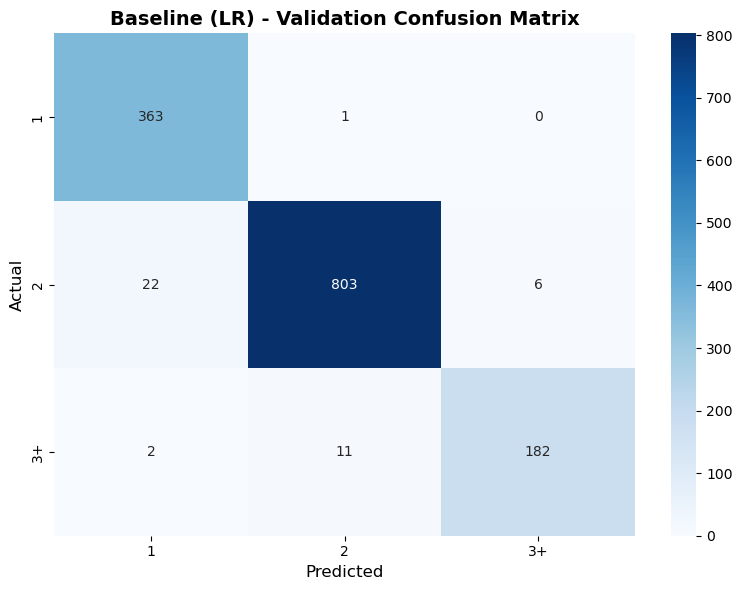

In [17]:
# =============================================================================
# 2.5 Confusion Matrix Visualization
# =============================================================================
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """"""
    labels_idx = np.arange(len(label_encoder.classes_))
    cm = confusion_matrix(y_true, y_pred, labels=labels_idx)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
        ax=ax
    )
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

fig = plot_confusion_matrix(y_val, y_val_pred, 'Baseline (LR) - Validation Confusion Matrix')
fig.savefig('model_artifacts/confusion_matrix_baseline_val.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# =============================================================================
# 2.6 Feature Importance (Top Words per Class)
# =============================================================================
# "interpreting top words per class for explainable article tagging"

feature_names = tfidf_vectorizer.get_feature_names_out()

def get_top_features(model, feature_names, class_idx, top_n=15):
    """"""
    coef = model.coef_[class_idx]
    #  TF-IDF  weather
    tfidf_coef = coef[:len(feature_names)]
    top_indices = np.argsort(tfidf_coef)[-top_n:][::-1]
    return [(feature_names[i], tfidf_coef[i]) for i in top_indices]

print(" Top Keywords per Class (Explainability):")
print("=" * 60)

for class_idx, class_name in enumerate(label_encoder.classes_):
    top_features = get_top_features(lr_model, feature_names, class_idx)
    print(f"\n Class '{class_name}' (Top 10 Keywords):")
    for word, score in top_features[:10]:
        print(f"   {word:20s} | Score: {score:.4f}")

 Top Keywords per Class (Explainability):

 Class '1' (Top 10 Keywords):
   single vehicle       | Score: 2.2859
   single               | Score: 2.2567
   edge                 | Score: 2.0454
   travel edge          | Score: 1.8049
   edge road            | Score: 1.7466
   pole                 | Score: 1.6754
   road                 | Score: 1.5094
   road right           | Score: 1.2937
   tree                 | Score: 1.2720
   roadway              | Score: 1.2678

 Class '2' (Top 10 Keywords):
   v2                   | Score: 6.3211
   intersection         | Score: 1.6812
   driver v2            | Score: 1.3349
   lane line            | Score: 1.2806
   direction            | Score: 1.1674
   line                 | Score: 1.1549
   event v2             | Score: 1.1474
   v2 cod               | Score: 1.1153
   encroachment         | Score: 1.0095
   vehicle encroachment | Score: 1.0067

 Class '3+' (Top 10 Keywords):
   v3                   | Score: 10.8408
   park                

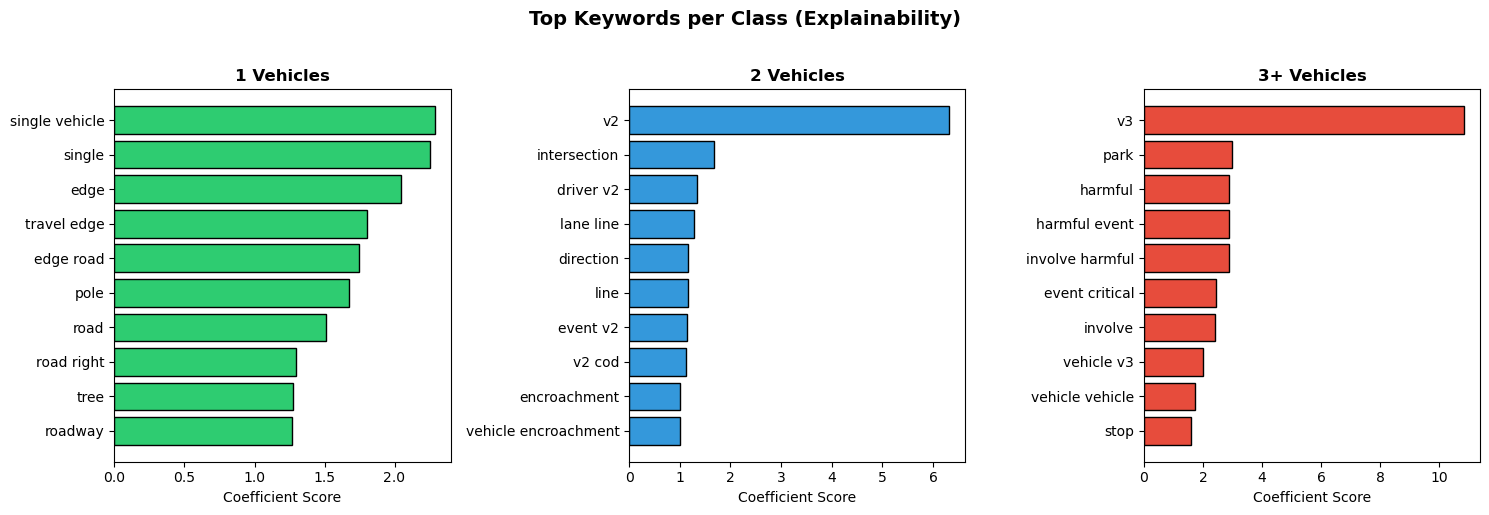


 Insight:
   - '1 Vehicle':  'single', 'only', 'driver' 
   - '3+ Vehicles':  'chain', 'pileup', 'multiple' 


In [19]:
# =============================================================================
# 2.7 Visualize Top Keywords
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#2ecc71', '#3498db', '#e74c3c']

for idx, (ax, class_name, color) in enumerate(zip(axes, label_encoder.classes_, colors)):
    top_features = get_top_features(lr_model, feature_names, idx, top_n=10)
    words = [f[0] for f in top_features]
    scores = [f[1] for f in top_features]
    
    ax.barh(words, scores, color=color, edgecolor='black')
    ax.set_xlabel('Coefficient Score')
    ax.set_title(f'{class_name} Vehicles', fontweight='bold')
    ax.invert_yaxis()

plt.suptitle('Top Keywords per Class (Explainability)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('model_artifacts/top_keywords.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Insight:")
print("   - '1 Vehicle':  'single', 'only', 'driver' ")
print("   - '3+ Vehicles':  'chain', 'pileup', 'multiple' ")

---

##  Section 3: Deep Learning Model (BiLSTM + Attention)

> **MLE ** PyTorch  Bidirectional LSTM with Attention Mechanism
>
> 
> 1. **Bidirectional LSTM**
> 2. **Attention Mechanism**
> 3. **Weighted Loss** Class Imbalance

In [20]:
# =============================================================================
# 3.1 Build Vocabulary
# =============================================================================
class Vocabulary:
    """word to index mapping
    
    Special tokens:
        <PAD>: 0 - Padding
        <UNK>: 1 - Unknown word
    """
    def __init__(self, max_size=None):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_freq = Counter()
        self.max_size = max_size
    
    def build(self, texts):
        """"""
        for text in texts:
            self.word_freq.update(text.split())
        
        # 
        if self.max_size:
            most_common = self.word_freq.most_common(self.max_size - 2)  # -2 for PAD and UNK
        else:
            most_common = self.word_freq.most_common()
        
        for word, _ in most_common:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word
        
        return self
    
    def encode(self, text):
        """ index """
        return [self.word2idx.get(word, 1) for word in text.split()]  # 1 = <UNK>
    
    def __len__(self):
        return len(self.word2idx)

# Build vocabulary from training data only!
vocab = Vocabulary(max_size=config.MAX_VOCAB_SIZE)
vocab.build(X_train['SUMMARY_LEMMA'])

print(f" Vocabulary Size: {len(vocab)}")
print(f" Sample words: {list(vocab.word2idx.keys())[2:12]}")

 Vocabulary Size: 5000
 Sample words: ['vehicle', 'lane', 'v1', 'driver', 'crash', 'critical', 'v2', 'travel', 'roadway', 'event']


In [21]:
# =============================================================================
# 3.2 PyTorch Dataset
# =============================================================================
class CrashReportDataset(Dataset):
    """ Dataset
    
     tensor weather features
    """
    def __init__(self, texts, weather_df, labels, vocab, max_len):
        self.texts = texts.values
        self.weather = weather_df[weather_cols].values.astype(np.float32)
        self.labels = labels.values
        self.vocab = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # Encode text
        encoded = self.vocab.encode(self.texts[idx])
        
        # Truncate or pad
        if len(encoded) > self.max_len:
            encoded = encoded[:self.max_len]
        
        length = len(encoded)
        
        # Convert to tensor
        text_tensor = torch.tensor(encoded, dtype=torch.long)
        weather_tensor = torch.tensor(self.weather[idx], dtype=torch.float32)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return text_tensor, weather_tensor, label_tensor, length

def collate_fn(batch):
    """Custom collate function for padding."""
    texts, weathers, labels, lengths = zip(*batch)
    
    # Pad sequences
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    
    return (
        texts_padded,
        torch.stack(weathers),
        torch.stack(labels),
        torch.tensor(lengths)
    )

In [22]:
# =============================================================================
# 3.3 Create DataLoaders
# =============================================================================
train_dataset = CrashReportDataset(
    X_train['SUMMARY_LEMMA'], X_train, y_train, vocab, config.MAX_SEQ_LENGTH
)
val_dataset = CrashReportDataset(
    X_val['SUMMARY_LEMMA'], X_val, y_val, vocab, config.MAX_SEQ_LENGTH
)
test_dataset = CrashReportDataset(
    X_test['SUMMARY_LEMMA'], X_test, y_test, vocab, config.MAX_SEQ_LENGTH
)

train_loader = DataLoader(
    train_dataset, batch_size=config.BATCH_SIZE, 
    shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=config.BATCH_SIZE,
    shuffle=False, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=config.BATCH_SIZE,
    shuffle=False, collate_fn=collate_fn
)

print(f" Train batches: {len(train_loader)}")
print(f" Val batches: {len(val_loader)}")
print(f" Test batches: {len(test_loader)}")

 Train batches: 261
 Val batches: 87
 Test batches: 87


In [23]:
# =============================================================================
# 3.4 Attention Layer
# =============================================================================
class Attention(nn.Module):
    """Dot-Product Attention Layer.
    
     attention weights
    Explainability
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Linear(hidden_dim, 1, bias=False)
    
    def forward(self, lstm_output, lengths):
        """
        Args:
            lstm_output: (batch_size, seq_len, hidden_dim)
            lengths: (batch_size,) - 
        
        Returns:
            context: (batch_size, hidden_dim) - weighted sum
            attention_weights: (batch_size, seq_len) - for visualization
        """
        # Compute attention scores
        scores = self.attention(lstm_output).squeeze(-1)  # (batch, seq_len)
        
        # Create mask for padding
        batch_size, max_len = scores.size()
        mask = torch.arange(max_len, device=scores.device).expand(batch_size, max_len) < lengths.unsqueeze(1)
        
        # Apply mask
        scores = scores.masked_fill(~mask, float('-inf'))
        
        # Softmax to get weights
        attention_weights = F.softmax(scores, dim=1)  # (batch, seq_len)
        
        # Weighted sum
        context = torch.bmm(attention_weights.unsqueeze(1), lstm_output).squeeze(1)  # (batch, hidden)
        
        return context, attention_weights

In [24]:
# =============================================================================
# Section 3.5: Intermediate Model - Simple Dense Net (DAN)
# =============================================================================
# Deep Averaging Network (DAN): Embedding -> (masked) average pooling -> MLP
#  Pros: fast, strong baseline
#  Cons: loses word order

import torch
import torch.nn as nn

class SimpleDenseNet(nn.Module):
    """DAN baseline (Embedding Avg + MLP).

    NOTE: forward signature matches the existing train loop:
        outputs, _ = model(texts, weathers, lengths)
    """
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, weather_dim=8, dropout=0.3, pad_idx=0):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        self.fc = nn.Sequential(
            nn.Linear(embed_dim + weather_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, text, weather, lengths):
        # text: (B, L), weather: (B, W), lengths: (B,)
        embedded = self.embedding(text)  # (B, L, D)

        # Masked mean pooling (avoid averaging PAD tokens)
        B, L, D = embedded.shape
        mask = (torch.arange(L, device=text.device).unsqueeze(0) < lengths.unsqueeze(1)).unsqueeze(-1)  # (B, L, 1)
        summed = (embedded * mask).sum(dim=1)  # (B, D)
        denom = lengths.unsqueeze(1).clamp(min=1).to(embedded.dtype)  # (B, 1)
        pooled = summed / denom  # (B, D)

        combined = torch.cat([pooled, weather], dim=1)  # (B, D+W)
        logits = self.fc(combined)  # (B, C)

        return logits, None


In [25]:
# =============================================================================
# 3.6 BiLSTM + Attention Model
# =============================================================================
class BiLSTMAttention(nn.Module):
    """Bidirectional LSTM with Attention for Text Classification.
    
    Architecture:
        Embedding → BiLSTM → Attention → FC → Output
    
     text features  weather features
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes,
                 num_layers=2, dropout=0.3, bidirectional=True, weather_dim=8):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        # Embedding layer
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=0
        )
        
        # BiLSTM
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Attention
        self.attention = Attention(hidden_dim * self.num_directions)
        
        # Fully connected layers
        fc_input_dim = hidden_dim * self.num_directions + weather_dim
        self.fc = nn.Sequential(
            nn.Linear(fc_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """"""
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
    
    def forward(self, text, weather, lengths):
        """
        Args:
            text: (batch_size, seq_len)
            weather: (batch_size, weather_dim)
            lengths: (batch_size,)
        
        Returns:
            output: (batch_size, num_classes)
            attention_weights: (batch_size, seq_len) - for explainability
        """
        # Embedding
        embedded = self.embedding(text)  # (batch, seq, emb_dim)
        
        # Pack for LSTM (handle variable lengths)
        packed = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # LSTM
        lstm_out, _ = self.lstm(packed)
        
        # Unpack
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        
        # Attention
        context, attention_weights = self.attention(lstm_out, lengths)
        
        # Concatenate with weather features
        combined = torch.cat([context, weather], dim=1)
        
        # Output
        output = self.fc(combined)
        
        return output, attention_weights

In [ ]:
# =============================================================================
# 3.7 Initialize Models (keep all)
# =============================================================================
SELECTED_DL_MODEL = "bilstm_attn"   # "bilstm_attn" or "dan"
DL_MODELS_TO_TRAIN = ["dan", "bilstm_attn"]  # train both for comparison; or set e.g. ["bilstm_attn"]

# --- DAN (Deep Averaging Network) ---
dan_model = SimpleDenseNet(
    vocab_size=len(vocab),
    embed_dim=config.EMBEDDING_DIM,
    hidden_dim=config.HIDDEN_DIM,
    output_dim=len(label_encoder.classes_),
    weather_dim=len(weather_cols),
    dropout=config.DROPOUT,
    pad_idx=0
).to(config.DEVICE)

# --- BiLSTM + Attention ---
bilstm_attn_model = BiLSTMAttention(
    vocab_size=len(vocab),
    embedding_dim=config.EMBEDDING_DIM,
    hidden_dim=config.HIDDEN_DIM,
    num_classes=len(label_encoder.classes_),
    num_layers=config.NUM_LAYERS,
    dropout=config.DROPOUT,
    bidirectional=config.BIDIRECTIONAL,
    weather_dim=len(weather_cols)
).to(config.DEVICE)

dl_models = {
    "dan": dan_model,
    "bilstm_attn": bilstm_attn_model
}

print(" Model Architectures:")
print("-" * 60)
print("DAN (SimpleDenseNet):")
print(dan_model)
print("-" * 60)
print("BiLSTM + Attention:")
print(bilstm_attn_model)

# Select one model for downstream explainability (attention viz expects BiLSTM)
model = dl_models[SELECTED_DL_MODEL]

# Parameter counts
def _count_params(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

for k, m in dl_models.items():
    total, trainable = _count_params(m)
    print(f"\n {k} params: total={total:,} | trainable={trainable:,}")


 Model Architectures:
------------------------------------------------------------
DAN (SimpleDenseNet):
SimpleDenseNet(
  (embedding): Embedding(5000, 64, padding_idx=0)
  (fc): Sequential(
    (0): Linear(in_features=72, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
)
------------------------------------------------------------
BiLSTM + Attention:
BiLSTMAttention(
  (embedding): Embedding(5000, 64, padding_idx=0)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Attention(
    (attention): Linear(in_features=128, out_features=1, bias=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=136, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
)

 dan params: total=324,867 | trainable=324,867

 bilstm_attn params: total=494,979 | trainab

In [27]:
# =============================================================================
# 3.7 Loss Function with Class Weights
# =============================================================================
# Convert class weights to tensor
class_weights_tensor = torch.tensor(
    [class_weight_dict[i] for i in range(len(class_weight_dict))],
    dtype=torch.float32
).to(config.DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

print(" Weighted CrossEntropyLoss initialized")
print(f"   Weights: {class_weights_tensor.cpu().numpy()}")

 Weighted CrossEntropyLoss initialized
   Weights: [1.2714242 0.5580991 2.371445 ]


In [28]:
# =============================================================================
# 3.9 Optimizer & Scheduler (builder)
# =============================================================================
def build_optimizer_scheduler(model):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.LEARNING_RATE,
        weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2
    )
    return optimizer, scheduler

print(" Optimizer/Scheduler builder ready")


 Optimizer/Scheduler builder ready


In [29]:
# =============================================================================
# 3.9 Training Functions
# =============================================================================
def train_epoch(model, loader, criterion, optimizer, device, max_batches=None):
    """ epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    batch_count = 0
    
    for texts, weathers, labels, lengths in loader:
        texts = texts.to(device)
        weathers = weathers.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        
        optimizer.zero_grad()
        
        outputs, _ = model(texts, weathers, lengths)
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        batch_count += 1
        if max_batches is not None and batch_count >= max_batches:
            break
    
    avg_loss = total_loss / batch_count if batch_count else 0
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # return predictions/labels for downstream metrics if needed
    return avg_loss, accuracy, f1, all_preds, all_labels


def evaluate(model, loader, criterion, device, max_batches=None):
    """"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    batch_count = 0
    
    with torch.no_grad():
        for texts, weathers, labels, lengths in loader:
            texts = texts.to(device)
            weathers = weathers.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            
            outputs, _ = model(texts, weathers, lengths)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            batch_count += 1
            if max_batches is not None and batch_count >= max_batches:
                break
    
    avg_loss = total_loss / batch_count if batch_count else 0
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels



In [30]:
# =============================================================================
# 3.11 Training Loop (DAN + BiLSTM+Attention) with Early Stopping
# =============================================================================
import copy

print(" Starting Training...")
print("=" * 70)

dl_results = {}

for model_key in DL_MODELS_TO_TRAIN:
    m = dl_models[model_key]
    optimizer, scheduler = build_optimizer_scheduler(m)

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    best_val_acc = -float("inf")
    patience_counter = 0
    best_model_state = copy.deepcopy(m.state_dict())

    run_name = f"dl_{model_key}"
    with mlflow.start_run(run_name=run_name):
        # Log hyperparameters
        params = {
            "model_key": model_key,
            "embedding_dim": config.EMBEDDING_DIM,
            "hidden_dim": config.HIDDEN_DIM,
            "num_layers": getattr(config, "NUM_LAYERS", None),
            "dropout": config.DROPOUT,
            "bidirectional": getattr(config, "BIDIRECTIONAL", None),
            "batch_size": config.BATCH_SIZE,
            "learning_rate": config.LEARNING_RATE,
            "epochs": config.EPOCHS,
            "max_train_batches": config.MAX_TRAIN_BATCHES,
            "max_val_batches": config.MAX_VAL_BATCHES
        }
        # mlflow params can't be None
        params = {k: v for k, v in params.items() if v is not None}
        mlflow.log_params(params)

        for epoch in range(config.EPOCHS):
            train_loss, train_acc, train_f1, train_preds, train_labels = train_epoch(
                m, train_loader, criterion, optimizer, config.DEVICE,
                max_batches=config.MAX_TRAIN_BATCHES
            )

            val_loss, val_acc, val_f1, val_preds, val_labels = evaluate(
                m, val_loader, criterion, config.DEVICE,
                max_batches=config.MAX_VAL_BATCHES
            )

            scheduler.step(val_acc)

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['train_f1'].append(train_f1)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_f1'].append(val_f1)

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_acc, step=epoch)
            mlflow.log_metric("train_f1", train_f1, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_accuracy", val_acc, step=epoch)
            mlflow.log_metric("val_f1", val_f1, step=epoch)

            print(f"[{model_key}] Epoch {epoch+1:02d}/{config.EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_model_state = copy.deepcopy(m.state_dict())
                print(f"    New best saved! Val Acc: {val_acc:.4f}")
            else:
                patience_counter += 1
                if patience_counter >= config.PATIENCE:
                    print(f"⏹ Early stopping triggered at epoch {epoch+1} for [{model_key}]")
                    break

        mlflow.log_metric("best_val_accuracy", best_val_acc)

    # Load best state back
    m.load_state_dict(best_model_state)
    dl_results[model_key] = {
        "best_val_acc": best_val_acc,
        "history": history,
        "best_state": best_model_state
    }

print("\n Training complete for:", list(dl_results.keys()))

# For downstream plots, keep 'history' as the selected model's training history
history = dl_results[SELECTED_DL_MODEL]["history"]
best_val_acc = dl_results[SELECTED_DL_MODEL]["best_val_acc"]
model = dl_models[SELECTED_DL_MODEL]
print(f"\n Selected model = {SELECTED_DL_MODEL} | Best Val Acc = {best_val_acc:.4f}")


 Starting Training...
[dan] Epoch 01/15 | Train Loss: 1.6445 | Train Acc: 0.6181 | Val Loss: 2.6645 | Val Acc: 0.8475 | Val F1: 0.8394
    New best saved! Val Acc: 0.8475
[dan] Epoch 02/15 | Train Loss: 4.8426 | Train Acc: 0.8309 | Val Loss: 0.3226 | Val Acc: 0.8791 | Val F1: 0.8822
    New best saved! Val Acc: 0.8791
[dan] Epoch 03/15 | Train Loss: 2.1654 | Train Acc: 0.8957 | Val Loss: 1.4081 | Val Acc: 0.9122 | Val F1: 0.9122
    New best saved! Val Acc: 0.9122
[dan] Epoch 04/15 | Train Loss: 1.5097 | Train Acc: 0.9271 | Val Loss: 0.2126 | Val Acc: 0.9158 | Val F1: 0.9172
    New best saved! Val Acc: 0.9158
[dan] Epoch 05/15 | Train Loss: 2.7943 | Train Acc: 0.9453 | Val Loss: 0.1929 | Val Acc: 0.9374 | Val F1: 0.9378
    New best saved! Val Acc: 0.9374
[dan] Epoch 06/15 | Train Loss: 1.9939 | Train Acc: 0.9566 | Val Loss: 1.0218 | Val Acc: 0.9417 | Val F1: 0.9424
    New best saved! Val Acc: 0.9417
[dan] Epoch 07/15 | Train Loss: 1.7676 | Train Acc: 0.9657 | Val Loss: 2.2765 | Val 

In [31]:
# =============================================================================
# Save Best Model States (for reuse without retraining)
# =============================================================================
from pathlib import Path

artifact_dir = Path("model_artifacts")
artifact_dir.mkdir(parents=True, exist_ok=True)

saved_paths = {}
for key, result in dl_results.items():
    state = result.get("best_state")
    if state is None:
        continue
    path = artifact_dir / f"{key}_best.pt"
    payload = {
        "state_dict": state,
        "config": vars(config),
        "label_encoder_classes": list(label_encoder.classes_),
        "vocab_word2idx": getattr(vocab, "word2idx", None)
    }
    torch.save(payload, path)
    saved_paths[key] = str(path)

print(" Saved best states:", saved_paths)


 Saved best states: {'dan': 'model_artifacts/dan_best.pt', 'bilstm_attn': 'model_artifacts/bilstm_attn_best.pt'}


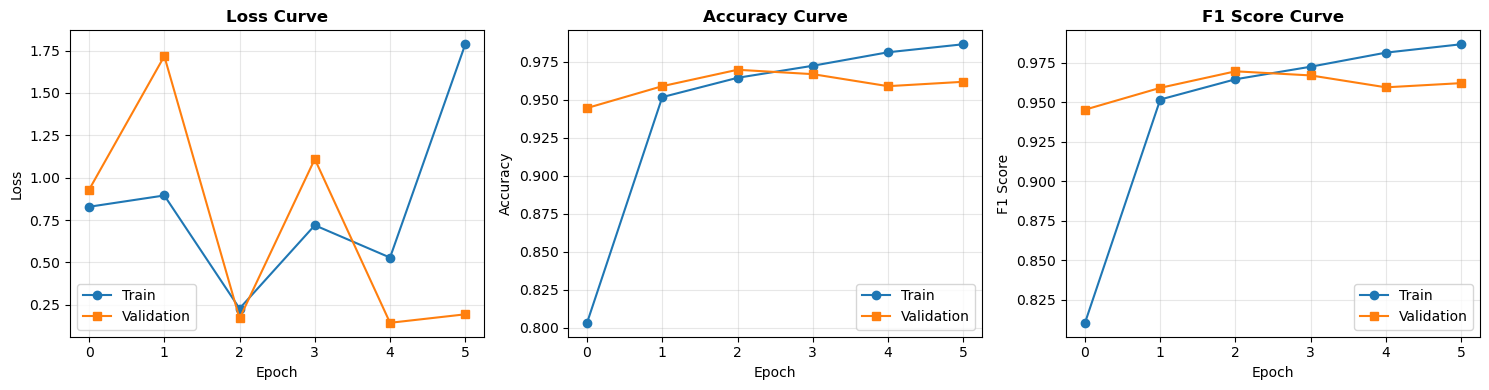

In [32]:
# =============================================================================
# 3.11 Training Curves Visualization
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train', marker='o')
axes[0].plot(history['val_loss'], label='Validation', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curve', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train', marker='o')
axes[1].plot(history['val_acc'], label='Validation', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Curve', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 Score
axes[2].plot(history['train_f1'], label='Train', marker='o')
axes[2].plot(history['val_f1'], label='Validation', marker='s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score Curve', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("model_artifacts/training_curves.png", dpi=300, bbox_inches="tight")
plt.show()

---

##  Section 4: Evaluation & Explainability

> **MLE ** minority class 

In [33]:
# =============================================================================
# 4.1 Final Evaluation on Test Set
# =============================================================================
print(" Final Evaluation on Test Set (run once after selecting via validation)")

# Baseline Logistic Regression (held-out test)
y_test_pred_base = lr_model.predict(X_test_combined)
baseline_test_acc = accuracy_score(y_test, y_test_pred_base)
baseline_test_f1 = f1_score(y_test, y_test_pred_base, average='weighted')
baseline_test_macro_f1 = f1_score(y_test, y_test_pred_base, average='macro')

# Deep Learning models (report once here)
dl_test_metrics = {}
for model_key, m in dl_models.items():
    if model_key not in dl_results:
        continue  # not trained

    test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
        m, test_loader, criterion, config.DEVICE
    )
    macro_f1 = f1_score(test_labels, test_preds, average='macro')
    dl_test_metrics[model_key] = {
        "loss": test_loss,
        "acc": test_acc,
        "f1": test_f1,
        "macro_f1": macro_f1
    }

print(" Final Test Results:")
print("=" * 60)
print(f"Baseline LR        | Test Acc: {baseline_test_acc:.4f} | Test F1 (w): {baseline_test_f1:.4f} | Macro F1: {baseline_test_macro_f1:.4f}")

if "dan" in dl_test_metrics:
    print(f"DAN (DAN)          | Test Acc: {dl_test_metrics['dan']['acc']:.4f} | Test F1 (w): {dl_test_metrics['dan']['f1']:.4f} | Macro F1: {dl_test_metrics['dan']['macro_f1']:.4f} | Loss: {dl_test_metrics['dan']['loss']:.4f}")

if "bilstm_attn" in dl_test_metrics:
    print(f"BiLSTM+Attention   | Test Acc: {dl_test_metrics['bilstm_attn']['acc']:.4f} | Test F1 (w): {dl_test_metrics['bilstm_attn']['f1']:.4f} | Macro F1: {dl_test_metrics['bilstm_attn']['macro_f1']:.4f} | Loss: {dl_test_metrics['bilstm_attn']['loss']:.4f}")

# Keep the selected model's test metrics in the original variable names for downstream cells
if SELECTED_DL_MODEL in dl_test_metrics:
    test_loss = dl_test_metrics[SELECTED_DL_MODEL]["loss"]
    test_acc = dl_test_metrics[SELECTED_DL_MODEL]["acc"]
    test_f1 = dl_test_metrics[SELECTED_DL_MODEL]["f1"]


 Final Evaluation on Test Set (run once after selecting via validation)
 Final Test Results:
Baseline LR        | Test Acc: 0.9784 | Test F1 (w): 0.9784 | Macro F1: 0.9742
DAN (DAN)          | Test Acc: 0.9590 | Test F1 (w): 0.9587 | Macro F1: 0.9472 | Loss: 0.1691
BiLSTM+Attention   | Test Acc: 0.9712 | Test F1 (w): 0.9710 | Macro F1: 0.9643 | Loss: 0.1900


In [34]:
# =============================================================================
# 4.2 Detailed Classification Report
# =============================================================================
print("\n Classification Report (Test Set):")
print(classification_report(
    test_labels, test_preds,
    target_names=[f'{label} Vehicles' for label in label_encoder.classes_]
))


 Classification Report (Test Set):
              precision    recall  f1-score   support

  1 Vehicles       0.96      0.99      0.97       365
  2 Vehicles       0.97      0.98      0.98       830
 3+ Vehicles       0.99      0.90      0.94       195

    accuracy                           0.97      1390
   macro avg       0.98      0.96      0.96      1390
weighted avg       0.97      0.97      0.97      1390



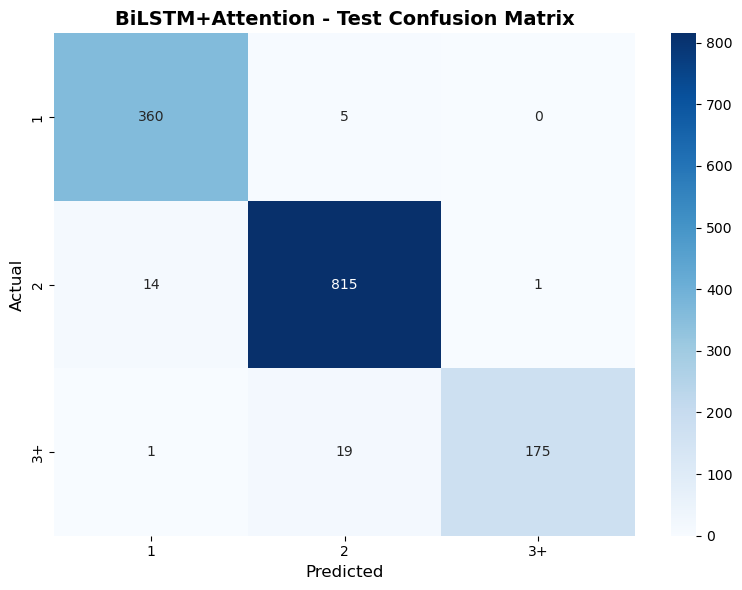

In [35]:
# =============================================================================
# 4.3 Confusion Matrix (Test)
# =============================================================================
plot_confusion_matrix(test_labels, test_preds, 'BiLSTM+Attention - Test Confusion Matrix')
plt.show()

In [36]:
# =============================================================================
# 4.4 Model Comparison (Baseline vs Deep Learning)
# =============================================================================
print(" Model Comparison:")
print("=" * 60)
print(f"{'Model':<30} | {'Val Acc':>10} | {'Test Acc':>10} | {'Test F1 (w)':>10} | {'Macro F1':>10}")
print("-" * 60)
rows = [
    {
        "name": "Logistic Regression (Baseline)",
        "val_acc": baseline_val_acc,
        "test_acc": baseline_test_acc,
        "test_f1": baseline_test_f1,
        "macro_f1": baseline_test_macro_f1
    },
    {
        "name": "DAN (Deep Averaging Net)",
        "val_acc": dl_results['dan']['best_val_acc'],
        "test_acc": dl_test_metrics['dan']['acc'],
        "test_f1": dl_test_metrics['dan']['f1'],
        "macro_f1": dl_test_metrics['dan']['macro_f1']
    },
    {
        "name": "BiLSTM + Attention",
        "val_acc": dl_results['bilstm_attn']['best_val_acc'],
        "test_acc": dl_test_metrics['bilstm_attn']['acc'],
        "test_f1": dl_test_metrics['bilstm_attn']['f1'],
        "macro_f1": dl_test_metrics['bilstm_attn']['macro_f1']
    }
]

for r in rows:
    print(f"{r['name']:<30} | {r['val_acc']:>10.4f} | {r['test_acc']:>10.4f} | {r['test_f1']:>10.4f} | {r['macro_f1']:>10.4f}")

print("=" * 60)

# Save table to CSV for reuse
import pandas as pd
df = pd.DataFrame(rows)
df.to_csv("model_artifacts/model_comparison.csv", index=False)


 Model Comparison:
Model                          |    Val Acc |   Test Acc | Test F1 (w) |   Macro F1
------------------------------------------------------------
Logistic Regression (Baseline) |     0.9698 |     0.9784 |     0.9784 |     0.9742
DAN (Deep Averaging Net)       |     0.9468 |     0.9590 |     0.9587 |     0.9472
BiLSTM + Attention             |     0.9698 |     0.9712 |     0.9710 |     0.9643


In [37]:
# =============================================================================
# 4.5 Attention Visualization (Explainability)
# =============================================================================
def visualize_attention(model, text, weather, vocab, device, max_len=50):
    """ Attention Weights
    
     Explainability 
    """
    model.eval()
    
    # Encode text
    encoded = vocab.encode(text)[:max_len]
    words = text.split()[:max_len]
    length = len(encoded)
    
    # Prepare tensors
    text_tensor = torch.tensor([encoded], dtype=torch.long).to(device)
    weather_tensor = torch.tensor([weather], dtype=torch.float32).to(device)
    length_tensor = torch.tensor([length]).to(device)
    
    with torch.no_grad():
        output, attention_weights = model(text_tensor, weather_tensor, length_tensor)
    
    # Get prediction
    pred = output.argmax(dim=1).item()
    probs = F.softmax(output, dim=1).squeeze().cpu().numpy()
    
    # Get attention weights
    attn = attention_weights.squeeze()[:length].cpu().numpy()
    
    return words, attn, pred, probs

def plot_attention(words, attention_weights, pred, probs, label_encoder, top_k=30):
    """ Attention """
    # Only show top_k words
    if len(words) > top_k:
        # Get indices of top attention words
        top_indices = np.argsort(attention_weights)[-top_k:]
        top_indices = sorted(top_indices)  # Keep original order
        words = [words[i] for i in top_indices]
        attention_weights = attention_weights[top_indices]
    
    fig, ax = plt.subplots(figsize=(14, 4))
    
    # Color mapping based on attention weight
    colors = plt.cm.Reds(attention_weights / attention_weights.max())
    
    # Create bar chart
    bars = ax.bar(range(len(words)), attention_weights, color=colors, edgecolor='black')
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Attention Weight')
    ax.set_title(f'Predicted: {label_encoder.classes_[pred]} Vehicles\n'
                 f'Probabilities: {dict(zip(label_encoder.classes_, [f"{p:.2f}" for p in probs]))}',
                 fontweight='bold')
    
    plt.tight_layout()
    return fig

 Attention Visualization Examples:

 Example 1 (True: 1 Vehicles):
   Predicted: 1 Vehicles
   Top Attention Words: ['single', 'entrance', 'ramp', 'northbound', 'vehicle']


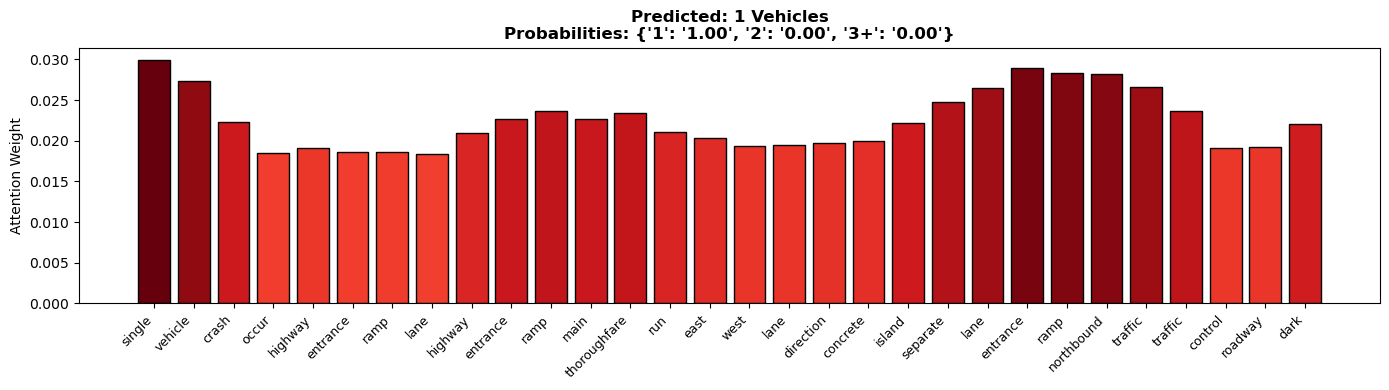


 Example 2 (True: 2 Vehicles):
   Predicted: 2 Vehicles
   Top Attention Words: ['v2', 'male', 'interview', 'old', 'vehicle']


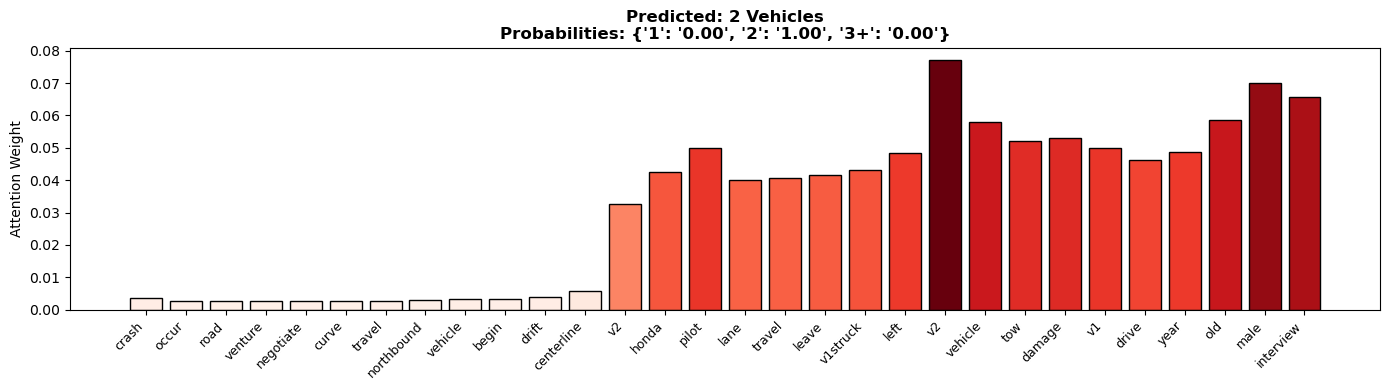


 Example 3 (True: 3+ Vehicles):
   Predicted: 3+ Vehicles
   Top Attention Words: ['v2', 'v3', 'lane', 'merge', 'v1']


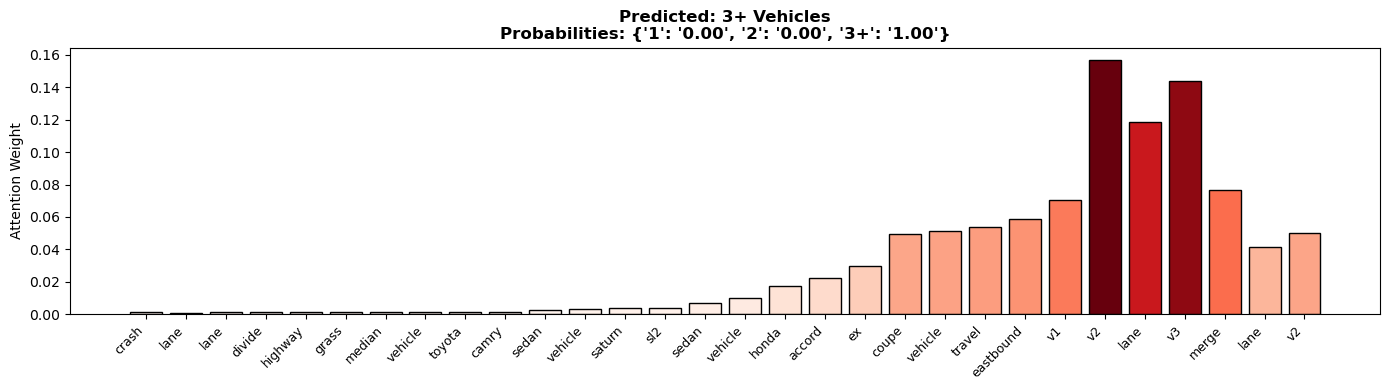

In [38]:
# =============================================================================
# 4.6 Attention Visualization Examples
# =============================================================================
if SELECTED_DL_MODEL != "bilstm_attn":
    print(" Attention visualization is only available for BiLSTM+Attention. Set SELECTED_DL_MODEL='bilstm_attn' to run this section.")
else:
    print(" Attention Visualization Examples:")
    print("=" * 60)

    # Get sample indices for each class
    sample_indices = []
    for cls in range(3):
        idx = np.where(y_test.values == cls)[0][0]
        sample_indices.append(idx)

    for i, idx in enumerate(sample_indices):
        sample_text = X_test['SUMMARY_LEMMA'].iloc[idx]
        sample_weather = X_test[weather_cols].iloc[idx].values.astype(np.float32)
        true_label = y_test.iloc[idx]

        words, attn, pred, probs = visualize_attention(
            model, sample_text, sample_weather, vocab, config.DEVICE
        )

        print(f"\n Example {i+1} (True: {label_encoder.classes_[true_label]} Vehicles):")
        print(f"   Predicted: {label_encoder.classes_[pred]} Vehicles")

        # Show top attention words
        top_indices = np.argsort(attn)[-5:][::-1]
        print(f"   Top Attention Words: {[words[j] for j in top_indices if j < len(words)]}")

        fig = plot_attention(words, attn, pred, probs, label_encoder)
        fig.savefig(f"model_artifacts/attention_example_{i+1}.png", dpi=300, bbox_inches='tight')
        plt.show()

---

##  Section 5: Model Saving & Deployment Ready

> **MLE **

In [39]:
# =============================================================================
# 5.1 Save Model Artifacts
# =============================================================================
import pickle

# Create output directory
output_dir = Path('model_artifacts')
output_dir.mkdir(exist_ok=True)

# Save PyTorch model (include vocab mappings for inference)
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'vocab_size': len(vocab),
        'embedding_dim': config.EMBEDDING_DIM,
        'hidden_dim': config.HIDDEN_DIM,
        'num_classes': len(label_encoder.classes_),
        'num_layers': config.NUM_LAYERS,
        'dropout': config.DROPOUT,
        'bidirectional': config.BIDIRECTIONAL
    },
    'history': history,
    'best_val_acc': best_val_acc,
    'vocab_word2idx': vocab.word2idx,
    'vocab_idx2word': vocab.idx2word
}, output_dir / 'bilstm_attention_model.pt')

# Save vocabulary (full object)
with open(output_dir / 'vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)

# Save label encoder
with open(output_dir / 'label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save TF-IDF vectorizer (for baseline)
with open(output_dir / 'tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save Logistic Regression model (baseline)
with open(output_dir / 'logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

print(f" All artifacts saved to {output_dir}/")
print(f"   Files: {[f.name for f in output_dir.iterdir()]}")



 All artifacts saved to model_artifacts/
   Files: ['tfidf_vectorizer.pkl', 'label_encoder.pkl', 'model_comparison.csv', 'attention_example_3.png', 'attention_example_2.png', 'attention_example_1.png', 'confusion_matrix_baseline_val.png', 'class_distribution.png', 'bilstm_attention_model.pt', 'dan_best.pt', 'training_curves.png', 'vocabulary.pkl', 'logistic_regression.pkl', 'top_keywords.png', 'bilstm_attn_best.pt']


In [40]:
# =============================================================================
# 5.2 Inference Function (Production Ready)
# =============================================================================
def predict_single(text: str, weather: list, model, vocab, label_encoder, device):
    """
    
    Args:
        text: 
        weather: Weather features [WEATHER1, ..., WEATHER8]
        model: Trained model
        vocab: Vocabulary object
        label_encoder: LabelEncoder object
        device: torch device
    
    Returns:
        dict: 
    """
    model.eval()
    
    # Preprocess
    text_clean = clean_text(text)
    text_lemma = lemmatize_text(text_clean)
    
    # Encode
    encoded = vocab.encode(text_lemma)[:config.MAX_SEQ_LENGTH]
    length = len(encoded)
    
    # To tensors
    text_tensor = torch.tensor([encoded], dtype=torch.long).to(device)
    weather_tensor = torch.tensor([weather], dtype=torch.float32).to(device)
    length_tensor = torch.tensor([length]).to(device)
    
    with torch.no_grad():
        output, attention = model(text_tensor, weather_tensor, length_tensor)
        probs = F.softmax(output, dim=1).squeeze().cpu().numpy()
        pred = output.argmax(dim=1).item()
    
    return {
        'prediction': label_encoder.classes_[pred],
        'probabilities': dict(zip(label_encoder.classes_, probs.tolist())),
        'confidence': float(probs.max())
    }

# Test inference
test_text = "Vehicle 1 struck Vehicle 2 which pushed it into Vehicle 3 causing a chain reaction crash."
test_weather = [0, 0, 0, 0, 0, 0, 0, 0]  # No special weather conditions

result = predict_single(test_text, test_weather, model, vocab, label_encoder, config.DEVICE)
print(" Inference Test:")
print(f"   Input: {test_text}")
print(f"   Prediction: {result['prediction']} Vehicles")
print(f"   Confidence: {result['confidence']:.2%}")
print(f"   Probabilities: {result['probabilities']}")

 Inference Test:
   Input: Vehicle 1 struck Vehicle 2 which pushed it into Vehicle 3 causing a chain reaction crash.
   Prediction: 3+ Vehicles
   Confidence: 95.40%
   Probabilities: {'1': 0.006819935981184244, '2': 0.03919472172856331, '3+': 0.9539853930473328}


In [ ]:
# Model Comparison (Visualization + Trade-off Table)
# =============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Color palette (LINE Green theme)
PRIMARY = "#06C755"   # LINE Green
BG = "#FFFFFF"        # Clean White
TEXT = "#1E1E1E"      # Dark Grey
SUBTEXT = "#666666"   # Subtitle Grey
TECH_BLUE = "#3B82F6" # Accent
LIGHT_GREY = "#F3F4F6"
ALERT_RED = "#EF4444"

# Load comparison data (fallback to known values if file is missing)
comparison_path = "model_comparison.csv"
if Path(comparison_path).exists():
    comp_df = pd.read_csv(comparison_path)
else:
    comp_df = pd.DataFrame([
        {"name": "Logistic Regression (Baseline)", "test_acc": 0.9784, "macro_f1": 0.9742},
        {"name": "BiLSTM + Attention", "test_acc": 0.9712, "macro_f1": 0.9643},
    ])

# Filter only the two target models
keep_names = ["Logistic Regression (Baseline)", "BiLSTM + Attention"]
comp_df = comp_df[comp_df["name"].isin(keep_names)].copy()
comp_df["test_acc_pct"] = comp_df["test_acc"] * 100
comp_df["macro_f1_pct"] = comp_df["macro_f1"] * 100

# Sort for stable plotting order
comp_df["name"] = pd.Categorical(comp_df["name"], categories=keep_names, ordered=True)
comp_df = comp_df.sort_values("name")

# Display heading
display(HTML(
    f"""
    <div style="font-family: Arial, sans-serif; color: {TEXT};">
      <h2 style="color: {PRIMARY}; margin-bottom: 4px;">Model Comparison</h2>
      <div style="color: {SUBTEXT}; margin-bottom: 12px;">
        Logistic Regression vs BiLSTM + Attention (Test Accuracy & Macro F1)
      </div>
    </div>
    """
))

# Bar chart: Test Acc vs Macro F1
fig, ax = plt.subplots(figsize=(8, 4.2), facecolor=BG)
ax.set_facecolor(BG)

x = range(len(comp_df))
bar_width = 0.35
ax.bar([i - bar_width/2 for i in x], comp_df["test_acc_pct"],
       width=bar_width, label="Test Acc", color=PRIMARY)
ax.bar([i + bar_width/2 for i in x], comp_df["macro_f1_pct"],
       width=bar_width, label="Macro F1", color=TECH_BLUE)

ax.set_xticks(list(x))
ax.set_xticklabels(comp_df["name"], rotation=0, color=TEXT)
ax.set_ylabel("Score (%)", color=TEXT)
ax.set_ylim(90, 100)
ax.tick_params(axis='y', colors=TEXT)
ax.spines[['top', 'right']].set_visible(False)
ax.spines['left'].set_color(LIGHT_GREY)
ax.spines['bottom'].set_color(LIGHT_GREY)
ax.grid(axis='y', color=LIGHT_GREY, linestyle='-', linewidth=1, alpha=0.8)

for i, v in enumerate(comp_df["test_acc_pct"]):
    ax.text(i - bar_width/2, v + 0.15, f"{v:.1f}%", ha='center', color=TEXT, fontsize=9)
for i, v in enumerate(comp_df["macro_f1_pct"]):
    ax.text(i + bar_width/2, v + 0.15, f"{v:.1f}%", ha='center', color=TEXT, fontsize=9)

ax.legend(frameon=False)
plt.tight_layout()
plt.show()

# Trade-off comparison table (styled)
tradeoff_rows = [
    ["Accuracy", f"{comp_df.loc[comp_df['name']=='Logistic Regression (Baseline)', 'test_acc_pct'].iloc[0]:.1f}%",
     f"{comp_df.loc[comp_df['name']=='BiLSTM + Attention', 'test_acc_pct'].iloc[0]:.1f}%"],
    ["Macro F1", f"{comp_df.loc[comp_df['name']=='Logistic Regression (Baseline)', 'macro_f1_pct'].iloc[0]:.1f}%",
     f"{comp_df.loc[comp_df['name']=='BiLSTM + Attention', 'macro_f1_pct'].iloc[0]:.1f}%"],
    ["Context ()", "Low (Keywords only)", "High (Sequential)"],
    ["Latency ()", "Fast (<~ms)", "Slower (~ms)"] ,
    ["Use Case ()", "Simple filtering ()", "Complex News Categorization ()"]
]

tradeoff_df = pd.DataFrame(tradeoff_rows, columns=["Metric", "Logistic Regression", "Bi-LSTM + Attention"])

# Build a lightweight HTML table for styling
html_table = [
    f"<div style='font-family: Arial, sans-serif; color: {TEXT};'>",
    f"<h3 style='color: {PRIMARY}; margin: 8px 0;'>Trade-off Comparison</h3>",
    f"<table style='border-collapse: collapse; width: 100%; background: {BG};'>",
    f"<thead>",
    f"<tr style='background: {LIGHT_GREY};'>",
    f"<th style='text-align: left; padding: 8px; color: {TEXT};'>Metric</th>",
    f"<th style='text-align: left; padding: 8px; color: {TEXT};'>Logistic Regression</th>",
    f"<th style='text-align: left; padding: 8px; color: {TEXT};'>Bi-LSTM + Attention</th>",
    f"</tr>",
    f"</thead>",
    f"<tbody>",
]
for row in tradeoff_df.itertuples(index=False):
    html_table.append(
        "<tr>"
        f"<td style='padding: 8px; border-bottom: 1px solid {LIGHT_GREY};'>{row.Metric}</td>"
        f"<td style='padding: 8px; border-bottom: 1px solid {LIGHT_GREY};'>{row[1]}</td>"
        f"<td style='padding: 8px; border-bottom: 1px solid {LIGHT_GREY};'>{row[2]}</td>"
        "</tr>"
    )
html_table += ["</tbody>", "</table>", "</div>"]

display(HTML("\n".join(html_table)))


---

##  Section 6: Summary & Key Takeaways

### 

| Model | Val Acc | Test Acc | Test F1 (w) | Macro F1 | Explainability |
|-------|--------:|---------:|------------:|---------:|---------------|
| Logistic Regression (Baseline) | 0.9698 | 0.9784 | 0.9784 | 0.9742 |  Coefficients |
| DAN (Deep Averaging Net) | 0.9468 | 0.9590 | 0.9587 | 0.9472 |  Attention-free |
| BiLSTM + Attention | 0.9698 | 0.9712 | 0.9710 | 0.9643 |  Attention Weights |

>  15 epochs  batch  macro-F1 

### Project Highlights

1. **End-to-end NLP pipeline**
   - Cleaning and lemmatization
   - TF-IDF baseline and neural models

2. **Class imbalance strategy**
   - Weighted CrossEntropyLoss
   - F1-focused evaluation

3. **PyTorch modeling**
   - Custom Dataset and DataLoader
   - BiLSTM with attention

4. **Interpretability**
   - Attention visualization for key tokens

5. **Reusable artifacts**
   - Saved model and vectorizer
   - Inference-ready helper

### Potential Applications

| Scenario | Value |
|----------|-------|
| Crash report triage | Faster routing and review |
| Severity tagging | Better prioritization |
| Trend analysis | Aggregate insights at scale |


## Part II — Binary Classification (INJSEVB) (PyTorch; teacher-parameter-matched)

This section reproduces the **Car Crash NLP Part II** task from Dr. Patrick Laub’s slides:

- Target: **INJSEVB** (binary presence of bodily injury)
- Text: **SUMMARY_EN**
- Split: test_size=0.2, then val_size=0.25 of remaining (so 0.2/0.2/0.6), random_state=1
- Standardize: `lower_and_strip_punctuation`
- Vocabulary: `max_tokens=1000`
- Sequence length: `max_length=500`
- Deep model core: **Embedding(32) + BiLSTM(24)**
- Binary setup: **BCEWithLogitsLoss + sigmoid** (PyTorch equivalent of `binary_crossentropy` + `sigmoid`)

> Note: The original slides use **BiLSTM (no attention)**.  
> I include an optional **attention** switch (`USE_ATTENTION=True/False`).  
> If you need the *closest match to teacher results*, set `USE_ATTENTION=False`.

In [41]:
# =============================================================================
# Part II (Binary) — Setup & Teacher Hyperparameters
# =============================================================================
import re
import random
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Reproducibility
# -------------------------
SEED = 1  # teacher uses random_state=1 for splitting; keep seed aligned
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Device:", DEVICE)

# -------------------------
# Teacher parameters (from slides)
# -------------------------
DATA_URL = "https://github.com/JSchelldorfer/ActuarialDataScience/raw/master/12%20-%20NLP%20Using%20Transformers/NHTSA_NMVCCS_extract.parquet.gzip"
DATA_PATH = "NHTSA_NMVCCS_extract.parquet.gzip"

MAX_TOKENS = 1000          # teacher: max_tokens = 1_000
MAX_LENGTH = 500           # teacher: max_length = 500 (for sequence models)
EMBED_DIM = 32             # teacher: Embedding(..., output_dim=32)
LSTM_HIDDEN = 24           # teacher: Bidirectional(LSTM(24))
BATCH_SIZE = 32            # Keras default is 32; good match for training
EVAL_BATCH_SIZE = 1000     # teacher evaluates with batch_size=1000
MAX_EPOCHS = 1000          # teacher sets epochs=1000 + EarlyStopping
PATIENCE = 10              # teacher: EarlyStopping(patience=10, monitor="val_accuracy")

USE_ATTENTION = True       # <-- set False to match teacher's BiLSTM (no attention)

def download_if_needed(url: str, out_path: str) -> None:
    p = Path(out_path)
    if p.exists():
        print(f" Dataset already exists: {out_path}")
        return
    print(" Downloading dataset...")
    import urllib.request
    urllib.request.urlretrieve(url, out_path)
    print(" Downloaded:", out_path)

download_if_needed(DATA_URL, DATA_PATH)

 Device: cpu
 Dataset already exists: NHTSA_NMVCCS_extract.parquet.gzip


In [42]:
# =============================================================================
# Part II (Binary) — Load data & splits (exactly like teacher)
# =============================================================================
df = pd.read_parquet(DATA_PATH)
print("shape:", df.shape)

# Teacher slides:
# features = df["SUMMARY_EN"]
# target = LabelEncoder().fit_transform(df["INJSEVB"])
features = df["SUMMARY_EN"].astype(str)
target = LabelEncoder().fit_transform(df["INJSEVB"])

X_main, X_test, y_main, y_test = train_test_split(
    features, target, test_size=0.2, random_state=1
)
X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size=0.25, random_state=1
)

print("shapes:", X_train.shape, X_val.shape, X_test.shape)
print("y distribution (train/val/test):",
      np.bincount(y_train), np.bincount(y_val), np.bincount(y_test))

shape: (6949, 16)
shapes: (4169,) (1390,) (1390,)
y distribution (train/val/test): [2393 1776] [765 625] [777 613]


In [43]:
# =============================================================================
# Part II (Binary) — Teacher-like standardization + vocab (max_tokens=1000)
# =============================================================================
# Keras TextVectorization standardize="lower_and_strip_punctuation"
# roughly: lowercase, replace punctuation with space, collapse whitespace
_punct_re = re.compile(r"[^\w\s]")

def standardize_teacher(text: str) -> str:
    text = text.lower()
    text = _punct_re.sub(" ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    text = standardize_teacher(text)
    return text.split() if text else []

# Build vocab from TRAIN only (teacher: vect.adapt(X_train))
# Mimic TextVectorization vocab: PAD=0, UNK=1, then most common tokens
PAD_TOKEN = ""
UNK_TOKEN = "[UNK]"

def build_vocab_topk(texts: pd.Series, max_tokens: int):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(str(t)))
    most_common = [w for (w, _) in counter.most_common(max_tokens - 2)]
    vocab_list = [PAD_TOKEN, UNK_TOKEN] + most_common
    return {w: i for i, w in enumerate(vocab_list)}

vocab = build_vocab_topk(X_train, MAX_TOKENS)
print("vocab size:", len(vocab))
print("first 20 vocab tokens:", list(vocab.keys())[:20])

def encode_text(text: str, vocab: dict, max_len: int) -> torch.Tensor:
    toks = tokenize(str(text))
    unk_id = vocab[UNK_TOKEN]
    ids = [vocab.get(w, unk_id) for w in toks[:max_len]]
    if len(ids) < max_len:
        ids.extend([0] * (max_len - len(ids)))
    return torch.tensor(ids, dtype=torch.long)

print("sanity:", encode_text(X_train.iloc[0], vocab, 20)[:20])

vocab size: 1000
first 20 vocab tokens: ['', '[UNK]', 'the', 'was', 'a', 'to', 'of', 'and', 'vehicle', 'v1', 'in', 'driver', 'for', 'lane', 'this', 'crash', 'v2', 'critical', 'he', 'on']
sanity: tensor([ 14,  15,  54,  10,   2, 261, 199,   6,   4, 178,  10,   2, 425,   6,
          4,  95,  68, 987,  29,   2])


In [44]:
# =============================================================================
# Part II (Binary) — Dataset & Dataloaders (shared pattern)
# =============================================================================
class TextBinaryDataset(Dataset):
    def __init__(self, texts: pd.Series, labels, vocab: dict, max_len: int):
        self.texts = texts.reset_index(drop=True)
        self.labels = np.asarray(labels).astype(np.float32)
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx: int):
        x = encode_text(self.texts.iloc[idx], self.vocab, self.max_len)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

train_ds = TextBinaryDataset(X_train, y_train, vocab, MAX_LENGTH)
val_ds   = TextBinaryDataset(X_val,   y_val,   vocab, MAX_LENGTH)
test_ds  = TextBinaryDataset(X_test,  y_test,  vocab, MAX_LENGTH)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=EVAL_BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=EVAL_BATCH_SIZE, shuffle=False)

print("batches:", len(train_loader), len(val_loader), len(test_loader))

batches: 131 2 2


In [45]:
# =============================================================================
# Part II (Binary) — Models (Teacher BiLSTM; optional Attention)
# =============================================================================
class BiLSTMTeacher(nn.Module):
    # Embedding(32) -> BiLSTM(24) -> Linear -> logits (teacher-equivalent)
    def __init__(self, vocab_size: int, embed_dim: int, hidden: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden * 2, 1)

    def forward(self, x):
        emb = self.embedding(x)        # (B, L, E)
        _, (h, _) = self.lstm(emb)     # h: (2, B, H)
        h_cat = torch.cat([h[-2], h[-1]], dim=1)  # (B, 2H)
        logits = self.fc(h_cat).squeeze(1)        # (B,)
        return logits

class AttentionPool(nn.Module):
    # simple additive attention over sequence outputs
    def __init__(self, in_dim: int):
        super().__init__()
        self.w = nn.Linear(in_dim, 1, bias=False)

    def forward(self, seq_out, mask):
        scores = self.w(seq_out).squeeze(-1)          # (B, L)
        scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=1)           # (B, L)
        ctx = torch.bmm(attn.unsqueeze(1), seq_out).squeeze(1)  # (B, D)
        return ctx

class BiLSTMAttention(nn.Module):
    # Embedding -> BiLSTM(return_sequences) -> AttentionPool -> Linear -> logits
    def __init__(self, vocab_size: int, embed_dim: int, hidden: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.attn = AttentionPool(hidden * 2)
        self.fc = nn.Linear(hidden * 2, 1)

    def forward(self, x):
        mask = (x != 0).to(x.device)
        emb = self.embedding(x)
        seq_out, _ = self.lstm(emb)                 # (B, L, 2H)
        ctx = self.attn(seq_out, mask)              # (B, 2H)
        logits = self.fc(ctx).squeeze(1)
        return logits

model = (BiLSTMAttention(len(vocab), EMBED_DIM, LSTM_HIDDEN) if USE_ATTENTION
         else BiLSTMTeacher(len(vocab), EMBED_DIM, LSTM_HIDDEN)).to(DEVICE)

print("model:", model.__class__.__name__)

model: BiLSTMAttention


In [46]:
# =============================================================================
# Part II (Binary) — Train loop (EarlyStopping on val_accuracy) + evaluation
# =============================================================================
def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()
    return (preds == y).float().mean().item()

@torch.no_grad()
def evaluate(loader: DataLoader, model: nn.Module, loss_fn: nn.Module):
    model.eval()
    losses, accs = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        loss = loss_fn(logits, y)
        losses.append(loss.item())
        accs.append(accuracy_from_logits(logits, y))
    return float(np.mean(losses)), float(np.mean(accs))

def train_binary(train_loader, val_loader, model, max_epochs=MAX_EPOCHS, patience=PATIENCE, lr=1e-3):
    loss_fn = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = -1.0
    best_state = None
    bad_epochs = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        train_losses, train_accs = [], []
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            optim.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optim.step()

            train_losses.append(loss.item())
            train_accs.append(accuracy_from_logits(logits.detach(), y))

        tr_loss = float(np.mean(train_losses))
        tr_acc  = float(np.mean(train_accs))
        va_loss, va_acc = evaluate(val_loader, model, loss_fn)

        print(f"Epoch {epoch:03d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} "
              f"| val loss {va_loss:.4f} acc {va_acc:.4f}")

        # Early stopping on val_accuracy (teacher)
        if va_acc > best_val_acc + 1e-6:
            best_val_acc = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f" Early stopping (patience={patience}). Best val_acc={best_val_acc:.4f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return best_val_acc

best_val_acc = train_binary(train_loader, val_loader, model)
print(" Best val_acc:", best_val_acc)

Epoch 001 | train loss 0.6714 acc 0.5768 | val loss 0.6277 acc 0.6451
Epoch 002 | train loss 0.5700 acc 0.6895 | val loss 0.5518 acc 0.7139
Epoch 003 | train loss 0.5351 acc 0.7181 | val loss 0.5369 acc 0.7311
Epoch 004 | train loss 0.4886 acc 0.7480 | val loss 0.4626 acc 0.7749
Epoch 005 | train loss 0.3749 acc 0.8303 | val loss 0.3087 acc 0.8715
Epoch 006 | train loss 0.2525 acc 0.9029 | val loss 0.2203 acc 0.9169
Epoch 007 | train loss 0.2079 acc 0.9222 | val loss 0.2019 acc 0.9253
Epoch 008 | train loss 0.1823 acc 0.9316 | val loss 0.1956 acc 0.9260
Epoch 009 | train loss 0.1688 acc 0.9380 | val loss 0.1913 acc 0.9285
Epoch 010 | train loss 0.1549 acc 0.9455 | val loss 0.1837 acc 0.9295
Epoch 011 | train loss 0.1386 acc 0.9521 | val loss 0.1918 acc 0.9290
Epoch 012 | train loss 0.1304 acc 0.9537 | val loss 0.1960 acc 0.9308
Epoch 013 | train loss 0.1237 acc 0.9550 | val loss 0.1859 acc 0.9268
Epoch 014 | train loss 0.1112 acc 0.9616 | val loss 0.2110 acc 0.9239
Epoch 015 | train lo

In [47]:
# =============================================================================
# Part II (Binary) — Final evaluation (train/val/test) + save
# =============================================================================
loss_fn = nn.BCEWithLogitsLoss()

train_loss, train_acc = evaluate(DataLoader(train_ds, batch_size=EVAL_BATCH_SIZE, shuffle=False), model, loss_fn)
val_loss, val_acc     = evaluate(val_loader, model, loss_fn)
test_loss, test_acc   = evaluate(test_loader, model, loss_fn)

print(f"Train: loss={train_loss:.4f} acc={train_acc:.4f}")
print(f"Val:   loss={val_loss:.4f} acc={val_acc:.4f}")
print(f"Test:  loss={test_loss:.4f} acc={test_acc:.4f}")

out_name = f"binary_injsevb_{'bilstm_attn' if USE_ATTENTION else 'bilstm_teacher'}.pt"
torch.save({"state_dict": model.state_dict(), "vocab": vocab}, out_name)
print(" Saved:", out_name)

# =============================================================================


Train: loss=0.0880 acc=0.9705
Val:   loss=0.1920 acc=0.9354
Test:  loss=0.1801 acc=0.9352
 Saved: binary_injsevb_bilstm_attn.pt
